In [103]:
# Importing required libraries

import sqlite3
from sqlite3 import Error
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'


In [104]:
#Extracting Data from SQLite DB

con = sqlite3.connect("E:\Database\Butterfly_Ayurveda_sqlite.db")
cur = con.cursor()

df = pd.read_sql('SELECT * FROM MIS', con)

df.head(10)

con.close()

In [105]:
# Filtering Medicine DB and droping off unwanted columns

Medicine = df.loc[df["Category"] == "Medicine"]
Medicine = Medicine.drop(columns =  ["Customer_ID", "Order_ID", "Category", "Order_recieved_by", "Customer_Name", "Contact_No",
                                     "Email", "Area", "State", "Description", "Net_Weight", "Base_Price", "Batch_Code",
                                     "Discount_given", "Price_Invoiced", "Total_Price", "Total_amt_wtht_tax", "GST",
                                     "Delivery_charges", "Total_Amount", "Invoice_No", "Invoice_Date", "Month",
                                     "Delivery_Date", "Delivery_TAT", "Return_Date", "Return_TAT", "Mode_of_Payment",
                                     "Status", "Cancelled_reason"],axis = 1)
Medicine
                                     
                                     

,Order_date,Quantity
0,1/6/2018,2
6,1/8/2018,10
7,1/8/2018,10
17,1/8/2018,50
36,1/11/2018,4
...,...,...
23770,3/13/2021,3
23776,3/14/2021,3
23777,3/14/2021,4
23778,3/14/2021,2


In [106]:
# Checking for null values in data

Medicine.isnull().sum()

Order_date    0
Quantity      0
dtype: int64

In [107]:
# Since values column are extracted as strings, converting them into numeric values 
Medicine["Quantity"] = pd.to_numeric(Medicine["Quantity"])

Medicine

,Order_date,Quantity
0,1/6/2018,2
6,1/8/2018,10
7,1/8/2018,10
17,1/8/2018,50
36,1/11/2018,4
...,...,...
23770,3/13/2021,3
23776,3/14/2021,3
23777,3/14/2021,4
23778,3/14/2021,2


In [108]:
# Checking Serenity of the data
Medicine["Quantity"].sum()

238925

In [109]:
# Creating datetime Index and resampling the data into months

Medicine = Medicine.set_index(pd.to_datetime(Medicine["Order_date"]))
Medicine = Medicine["Quantity"].resample('M').sum()
Medicine

Order_date
2018-01-31       81
2018-02-28       10
2018-03-31      246
2018-04-30      649
2018-05-31     1831
2018-06-30     1780
2018-07-31     3601
2018-08-31      912
2018-09-30     2176
2018-10-31     1613
2018-11-30     2767
2018-12-31     1956
2019-01-31     6096
2019-02-28     5589
2019-03-31      427
2019-04-30     4501
2019-05-31     3702
2019-06-30     6546
2019-07-31     8060
2019-08-31    10192
2019-09-30     8832
2019-10-31     5504
2019-11-30    12531
2019-12-31    19160
2020-01-31     8004
2020-02-29    10547
2020-03-31      856
2020-04-30     9335
2020-05-31    10588
2020-06-30     9269
2020-07-31    12960
2020-08-31    15121
2020-09-30    13469
2020-10-31    10639
2020-11-30    15195
2020-12-31     2710
2021-01-31     6363
2021-02-28     4477
2021-03-31      630
Freq: M, Name: Quantity, dtype: int64

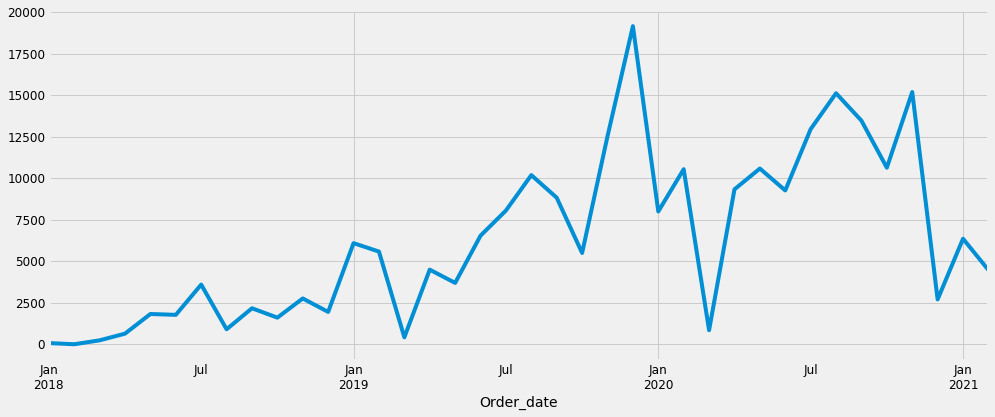

In [110]:
# On discovering, Last month data was found limted, thus excluding the same and ploting it 
y = Medicine[:-1]
y.plot(figsize=(15, 6))
plt.show()

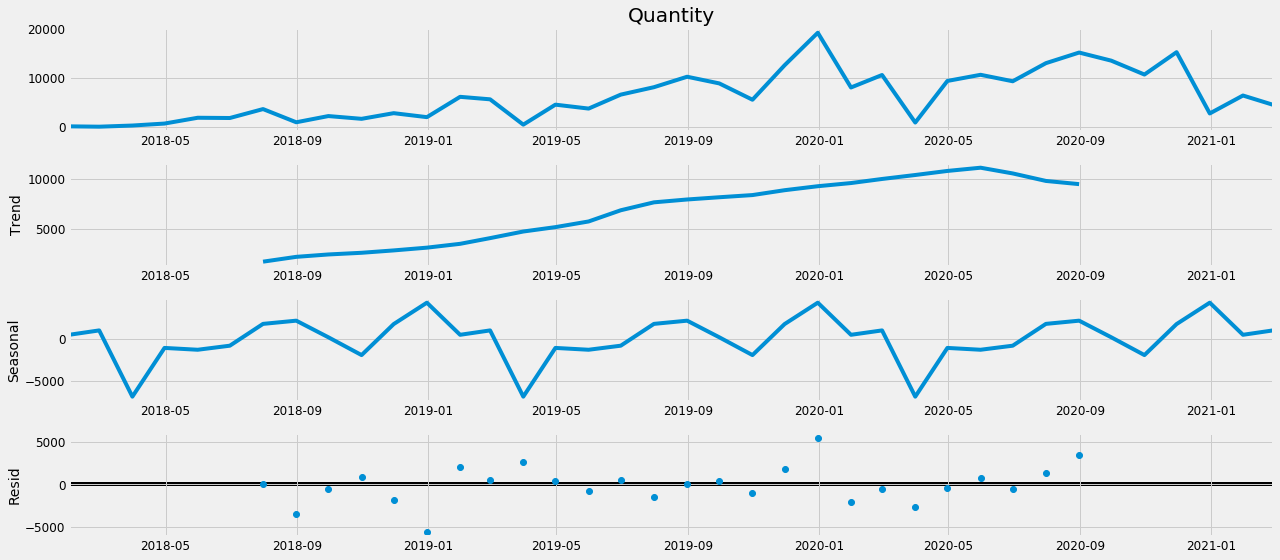

In [111]:
# Plotting time series compnents from the data

from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

In [112]:
# Now its time for ARIMA modeling. We are going to keep or range from 0-2 for our ARIMA model 
# Creating loops for all orders
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [114]:
# Checking the stationarity of the series. If P value < 0.05, 
# Reject the null hypothesis (H0), the data does not have a unit root and is stationary. 

from statsmodels.tsa.stattools import adfuller

result = adfuller(y)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])



ADF Statistic: -3.062557
p-value: 0.029451


In [115]:
# Fitting the SARIMX model and printing out all AIC scores

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:773.1369207580068
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1125.155006848715
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:514.050396038727
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:268.2786048250715
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:536.2838382645118
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:512.4250497714825
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:287.4501229349396
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:269.9546050921376
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:734.379819359479
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2085.591062391197
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:492.0456182474298
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:248.76148110642677
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:536.9718601123376
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:494.5202953140351
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:288.57191849567516
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:249.84521385669862
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:709.4607577857327
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:nan
ARIMA(0, 1, 0)x(0, 1, 0

The above score suggests AIC: ARIMA(0, 1, 1)x(0, 1, 1, 12)12 has recieved the lowest scores.

In [116]:
# Lowest AIC: ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:220.30305075173965
# Thus we will use the above order for our forecasting 

mod = sm.tsa.statespace.SARIMAX(y,
                                order=(0, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7171      0.343     -2.091      0.037      -1.389      -0.045
ma.S.L12      -1.3544      0.273     -4.965      0.000      -1.889      -0.820
sigma2       1.34e+07   1.75e-08   7.64e+14      0.000    1.34e+07    1.34e+07


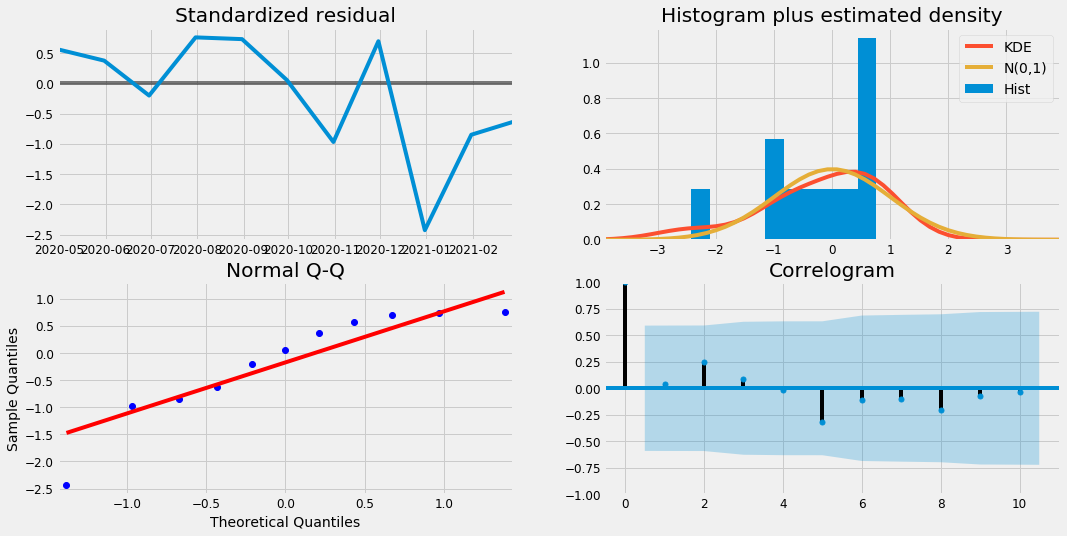

In [117]:
# Plotting the diagnosis of the data

results.plot_diagnostics(figsize=(16, 8))
plt.show()

Its not as perfect as we would've liked, but model diagnostics suggests that the model residuals are near normally distributed

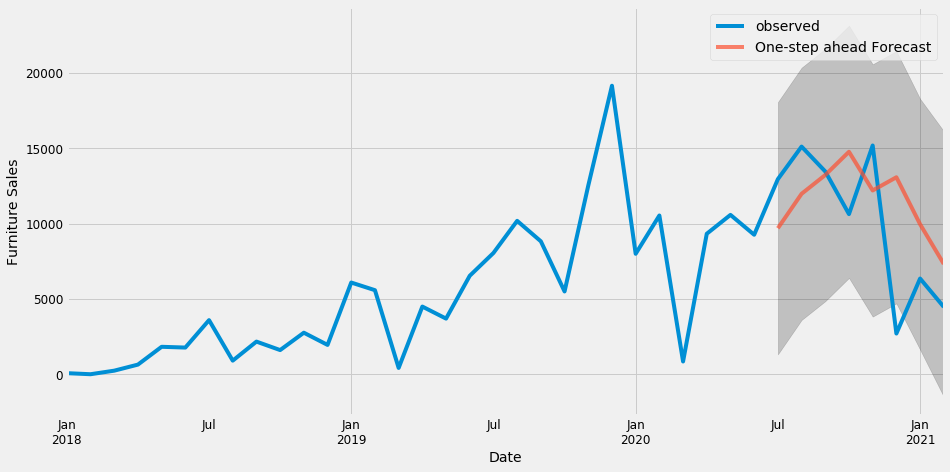

In [118]:
# Validating our data with the forecasts

pred = results.get_prediction(start=pd.to_datetime('2020-07-31'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2018':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

In [119]:
y_forecasted = pred.predicted_mean
y_truth = y['2020-07-31':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 21912095.5


In [120]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 4681.04


The RMSE shows the average sale of 4681 units per month, which is close to our actual aveage sale which is close tp 6K. Tgus our model is pretty good so far  

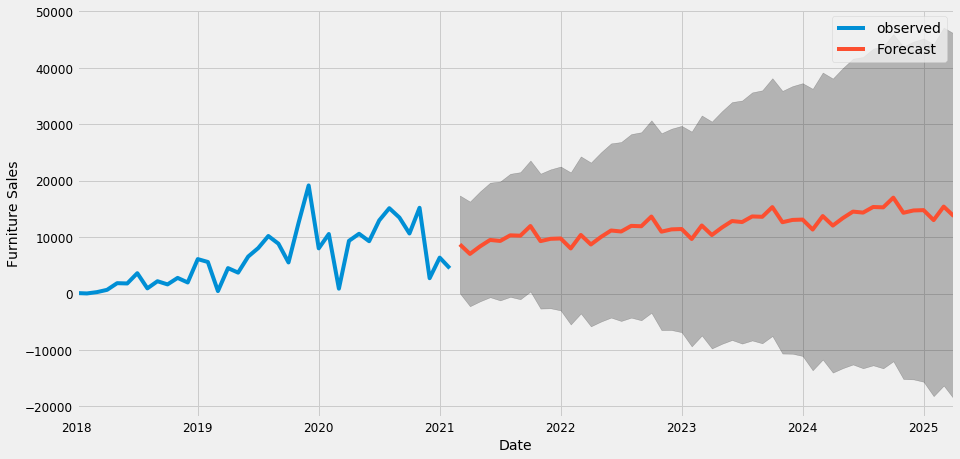

In [121]:
# Predicting and Plotting the forecatsed results

pred_uc = results.get_forecast(steps=50)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

The model acquired the the seasonality of our past data and predicted values. As we go more deep in the future values, our values get more spreaded which is natural

In [122]:
## Creating Forecast Dataframe

Forecast = pd.DataFrame(pred_uc.predicted_mean)
Forecast[1] = Forecast[0]
Forecast[0] = Forecast.index
Forecast.columns = ["Date","Forecast"]
print(Forecast)

                 Date      Forecast
2021-03-31 2021-03-31   8704.391026
2021-04-30 2021-04-30   7018.677603
2021-05-31 2021-05-31   8349.885054
2021-06-30 2021-06-30   9494.421002
2021-07-31 2021-07-31   9315.698196
2021-08-31 2021-08-31  10313.504284
2021-09-30 2021-09-30  10247.114076
2021-10-31 2021-10-31  11965.280348
2021-11-30 2021-11-30   9285.951414
2021-12-31 2021-12-31   9694.069353
2022-01-31 2022-01-31   9755.604357
2022-02-28 2022-02-28   7987.612082
2022-03-31 2022-03-31  10379.203290
2022-04-30 2022-04-30   8693.489867
2022-05-31 2022-05-31  10024.697318
2022-06-30 2022-06-30  11169.233266
2022-07-31 2022-07-31  10990.510460
2022-08-31 2022-08-31  11988.316549
2022-09-30 2022-09-30  11921.926341
2022-10-31 2022-10-31  13640.092612
2022-11-30 2022-11-30  10960.763678
2022-12-31 2022-12-31  11368.881617
2023-01-31 2023-01-31  11430.416621
2023-02-28 2023-02-28   9662.424346
2023-03-31 2023-03-31  12054.015555
2023-04-30 2023-04-30  10368.302131
2023-05-31 2023-05-31  11699

In [123]:
## Creating Actual sales Dataframe

y_Df = pd.DataFrame(y)
y_Df["Sales"] = y_Df["Quantity"]
y_Df["Quantity"] = y_Df.index
y_Df.columns = ["Date","Sales"]
print(y_Df)

                 Date  Sales
Order_date                  
2018-01-31 2018-01-31     81
2018-02-28 2018-02-28     10
2018-03-31 2018-03-31    246
2018-04-30 2018-04-30    649
2018-05-31 2018-05-31   1831
2018-06-30 2018-06-30   1780
2018-07-31 2018-07-31   3601
2018-08-31 2018-08-31    912
2018-09-30 2018-09-30   2176
2018-10-31 2018-10-31   1613
2018-11-30 2018-11-30   2767
2018-12-31 2018-12-31   1956
2019-01-31 2019-01-31   6096
2019-02-28 2019-02-28   5589
2019-03-31 2019-03-31    427
2019-04-30 2019-04-30   4501
2019-05-31 2019-05-31   3702
2019-06-30 2019-06-30   6546
2019-07-31 2019-07-31   8060
2019-08-31 2019-08-31  10192
2019-09-30 2019-09-30   8832
2019-10-31 2019-10-31   5504
2019-11-30 2019-11-30  12531
2019-12-31 2019-12-31  19160
2020-01-31 2020-01-31   8004
2020-02-29 2020-02-29  10547
2020-03-31 2020-03-31    856
2020-04-30 2020-04-30   9335
2020-05-31 2020-05-31  10588
2020-06-30 2020-06-30   9269
2020-07-31 2020-07-31  12960
2020-08-31 2020-08-31  15121
2020-09-30 202

In [124]:
## Merging both DFs

df = pd.merge(Forecast,y_Df,how="outer",on="Date")
df

,Date,Forecast,Sales
0,2021-03-31,8704.391026,NaN
1,2021-04-30,7018.677603,NaN
2,2021-05-31,8349.885054,NaN
3,2021-06-30,9494.421002,NaN
4,2021-07-31,9315.698196,NaN
...,...,...,...
83,2020-10-31,NaN,10639.0
84,2020-11-30,NaN,15195.0
85,2020-12-31,NaN,2710.0
86,2021-01-31,NaN,6363.0


In [97]:
# Importing data back to SQL DB 

con = sqlite3.connect("E:\Database\Butterfly_Ayurveda_sqlite.db")
cur = con.cursor()
df.to_sql('Forecast', con)

In [100]:
# Checking the data wether is completley ingested or not

fetch = cur.execute("SELECT * FROM Forecast;")
print(fetch.fetchall())
con.close()

[(0, '2021-03-31 00:00:00', 8704.39102615409, None), (1, '2021-04-30 00:00:00', 7018.677602944204, None), (2, '2021-05-31 00:00:00', 8349.885054247114, None), (3, '2021-06-30 00:00:00', 9494.421001718147, None), (4, '2021-07-31 00:00:00', 9315.698195516645, None), (5, '2021-08-31 00:00:00', 10313.504284384479, None), (6, '2021-09-30 00:00:00', 10247.114076489446, None), (7, '2021-10-31 00:00:00', 11965.280347795087, None), (8, '2021-11-30 00:00:00', 9285.95141390319, None), (9, '2021-12-31 00:00:00', 9694.069352619188, None), (10, '2022-01-31 00:00:00', 9755.604356727186, None), (11, '2022-02-28 00:00:00', 7987.61208182279, None), (12, '2022-03-31 00:00:00', 10379.203290370218, None), (13, '2022-04-30 00:00:00', 8693.489867160331, None), (14, '2022-05-31 00:00:00', 10024.69731846324, None), (15, '2022-06-30 00:00:00', 11169.233265934276, None), (16, '2022-07-31 00:00:00', 10990.510459732774, None), (17, '2022-08-31 00:00:00', 11988.316548600607, None), (18, '2022-09-30 00:00:00', 11921